In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt

from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py

In [2]:
keras.__version__

'2.11.0'

In [3]:
def print_progress(count, max_count):
    
    pct_complete = count / max_count

    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    sys.stdout.write(msg)
    sys.stdout.flush()

In [4]:
in_dir = "data"

In [5]:
img_size = 224
img_size_touple = (img_size, img_size)

num_channels = 3
img_size_flat = img_size * img_size * num_channels

num_classes = 4

_images_per_file = 20

In [6]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    frames_list = []
    video_reader = cv2.VideoCapture(in_file)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    list = np.linspace(1, video_frames_count-2, _images_per_file, endpoint=True)
    skip_frames_window = max(int(video_frames_count/_images_per_file), 1)

    for frame_counter in list:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, int(frame_counter))
        
        success, frame = video_reader.read()

        if not success:
            break

        RGB_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
        frames_list.append(res)
    
    
    video_reader.release()
    resul = np.array(frames_list)
    
    resul = (resul / 255.).astype(np.float16)
    return resul

In [7]:
def label_video_names(in_dir):
    
    names = []
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'As':
                labels.append([0,0,0,1])
                names.append("Assault/"+file_name)
            elif file_name[0:2] == 'Ex':
                labels.append([0,0,1,0])
                names.append("Explosion/"+file_name)
            elif file_name[0:2] == 'No':
                labels.append([0,1,0,0])
                names.append("Normal/"+file_name)
            elif file_name[0:2] == 'Ro':
                labels.append([1,0,0,0])
                names.append("RoadAccidents/"+file_name)
                     
            
    c = list(zip(names,labels))
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [8]:
names, labels = label_video_names(in_dir)

In [9]:
len(names)

892

In [10]:
frames = get_frames(in_dir, names[89])

In [11]:
visible_frame = (frames*255).astype('uint8')
len(visible_frame)

20

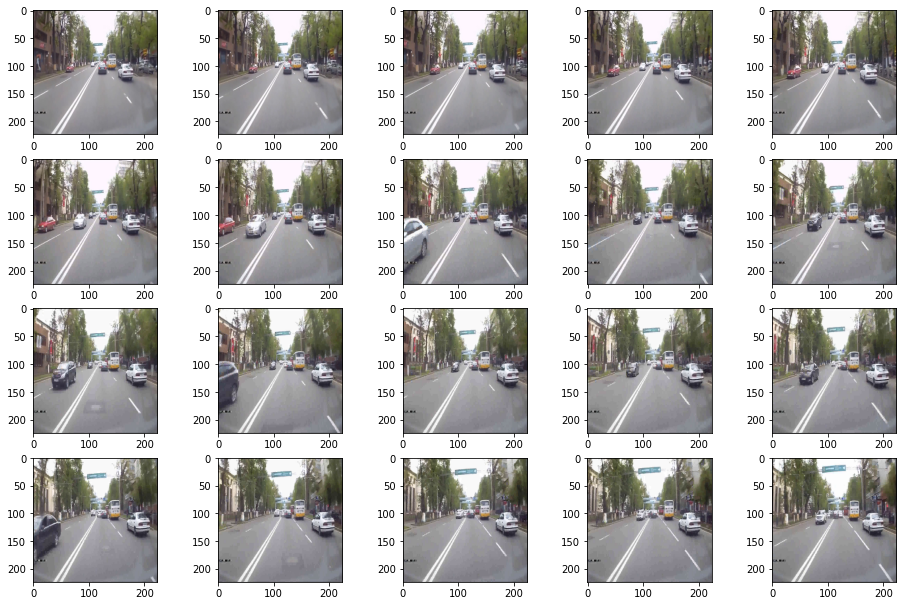

In [12]:
from matplotlib.pyplot import imshow
fig = plt.figure(figsize=(16,16))

for i,rand_indx in enumerate(visible_frame):
    ax = plt.subplot(6,5,i+1)
   
    plt.imshow(rand_indx)

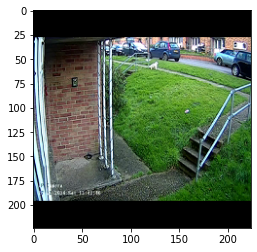

In [14]:
plt.imshow(visible_frame[15])

In [13]:
image_model = MobileNetV2( include_top=True, weights='imagenet')

In [14]:
image_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [15]:
transfer_layer = image_model.get_layer('global_average_pooling2d')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the Mobilenet have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of Mobilenet have dimensions: ", transfer_values_size)

The input of the Mobilenet have dimensions: (224, 224)
The output of the selecter layer of Mobilenet have dimensions:  1280


In [16]:
def get_transfer_values(current_dir, file_name):
    
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
    
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

In [17]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,4])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

In [18]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('train_20_data.h5', 'w') as f:
    
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [19]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('test_20_data.h5', 'w') as f:
    
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [21]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [22]:
print(names_test[20:40])
print(labels_test[20:40])

('RoadAccidents/RoadAccident (94).mp4', 'Assault/Assault (194).mp4', 'Normal/Normal (126).mp4', 'Assault/Assault (59).mp4', 'Normal/Normal (17).mp4', 'Assault/Assault (135).mp4', 'Assault/Assault (140).mp4', 'Assault/Assault (43).mp4', 'Assault/Assault (150).mp4', 'Explosion/Explosion (33).mp4', 'Normal/Normal (140).mp4', 'Assault/Assault (176).mp4', 'RoadAccidents/RoadAccident (121).mp4', 'RoadAccidents/RoadAccident (61).mp4', 'RoadAccidents/RoadAccident (228).mp4', 'RoadAccidents/RoadAccident (24).mp4', 'Explosion/Explosion (97).mp4', 'Assault/Assault (164).mp4', 'Explosion/Explosion (66).mp4', 'Explosion/Explosion (68).mp4')
([1, 0, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0])


In [23]:
len(names)

892

In [24]:
make_files(training_set)

1/1 [==============================] - 1s 684ms/step
- Progress: 99.9%

In [25]:
make_files_test(test_set)

1/1 [==============================] - 1s 658ms/step


In [20]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('train_20_data.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [21]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('test_20_data.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [18]:
data, target = process_alldata_training()

In [19]:
len(data)

713

In [20]:
data_test, target_test = process_alldata_test()

In [1]:
chunk_size = 1280
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

NameError: name 'Sequential' is not defined

## Model training


In [23]:
epoch = 25
batchS = 50

history = model.fit(np.array(data[0:650]), np.array(target[0:650]), epochs=epoch,
                    validation_data=(np.array(data[650:]), np.array(target[650:])), 
                    batch_size=batchS, verbose=2)

NameError: name 'data' is not defined

In [23]:
result = model.evaluate(np.array(data_test), np.array(target_test))

6/6 [==============================] - 1s 176ms/step - loss: 0.5691 - accuracy: 0.8596


In [24]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.5690820217132568
accuracy 0.8595505356788635


In [86]:
model.save("mob_20f_1.h5")


In [91]:
from tensorflow.keras.models import load_model
new_model = load_model("mob_20f_c1.h5")

In [105]:
tes = get_transfer_values("","D:\Capstone Project\Codes\Dataset//nonacc.mp4")

1/1 [==============================] - 1s 736ms/step


In [106]:
test_result = new_model.predict(np.array([tes]))
test_result

1/1 [==============================] - 0s 157ms/step


array([[0.00972401, 0.98682576, 0.00110791, 0.0023423 ]], dtype=float32)

In [52]:
target_test[2]

array([1., 0., 0., 0.])

In [28]:
pred = model.predict(np.array(data_test))

6/6 [==============================] - 1s 144ms/step


In [29]:
la_te = []
pr_te = []
for i in range(len(data_test)):

    la_te.append(np.argmax(target_test[i]))
    pr_te.append(np.argmax(pred[i]))

Text(0.5, 1.0, 'Confusion Matrix')

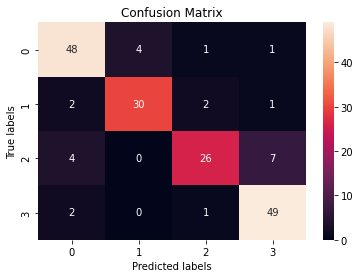

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(la_te, pr_te)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')